In [1]:
import wandb
from datetime import datetime

In [2]:

batch_size= 128
lr=1e-3
wd=1e-6
model_params = [17,1024,2,128]
model_name='biGRU-max'
milestones = [200, 400, 600]
epochs = 800

In [3]:
wandb_entity='longyi'

wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "model_params" : model_params,
})
wandb.run.name = f'det_score_{model_name}_' + datetime.now().strftime("%H%M%S")

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


In [4]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

import torchvision.transforms.functional as TF
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, "train_axial_images_jpeg95")

In [7]:
total_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_detection_score.csv')).set_index('index')
total_df = total_df.fillna(0.0)
print(len(total_df))
total_df.iloc[100:150]

708779


,UID,z_spacing,pixel_spacing,aspect,is_flip,patient_overall,C1,C2,C3,C4,...,axial_index,class_index,class_value,bbox_area,bbox_seg_area,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,bbox_score
index,,,,,,,,,,,,,,,,,,,,,
100,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,100.0,2.0,2.0,0.140579,0.091935,79.318260,199.154312,301.093689,365.529938,0.020178
101,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,101.0,2.0,2.0,0.126892,0.096200,85.672935,204.173996,301.108154,358.508057,0.013273
102,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,102.0,2.0,2.0,0.027100,0.561374,230.504486,189.149139,304.414551,285.134521,0.022776
103,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,103.0,0.0,0.0,0.093567,0.000000,328.620087,-38.443001,475.168457,131.328934,0.012729
104,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,104.0,2.0,2.0,0.035248,0.479221,225.005600,187.549606,335.031708,271.421082,0.028590
105,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,105.0,2.0,2.0,0.037766,0.406869,221.140213,185.625961,331.700531,274.248749,0.114510
106,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,106.0,2.0,2.0,0.038055,0.350040,219.497589,185.722076,335.034302,271.051239,0.024005
107,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,107.0,0.0,0.0,0.116730,0.000000,320.328308,-45.024319,490.582153,136.374283,0.018379
108,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,108.0,0.0,0.0,0.093079,0.000000,123.544029,329.466248,367.082184,428.453461,0.011806


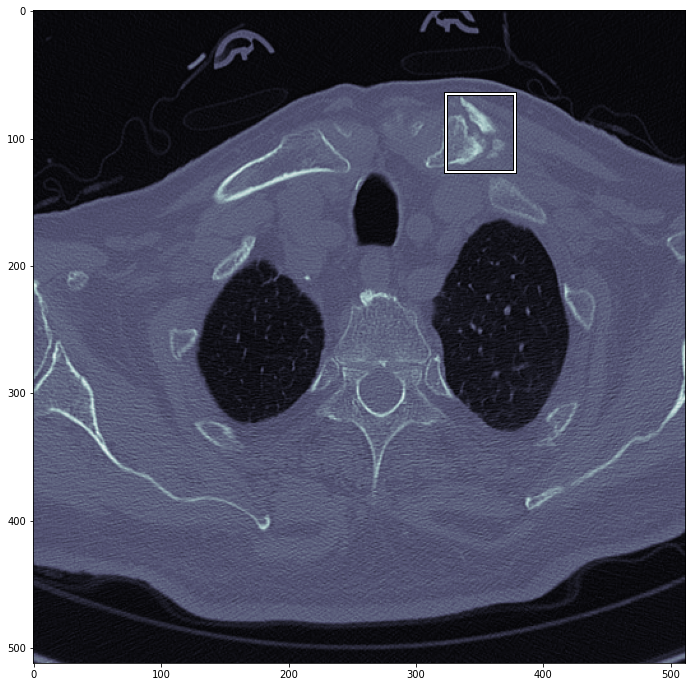

In [8]:
def draw_bbox(plot_ax,bbox):
    bottom_left, width, height = (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1]

    rect_1 = patches.Rectangle(
        bottom_left,
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        bottom_left,
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)

def show_bbox(index):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    s = total_df.iloc[index]
    img = Image.open(os.path.join(IMAGES_DIR, s.UID, f'{int(s.axial_index)}.jpeg'))
    ax.imshow(img, cmap='bone')

    draw_bbox(ax, s[['bbox_xmin','bbox_ymin','bbox_xmax','bbox_ymax']])

    plt.show()

show_bbox(33487)

In [9]:
# only pick class_index is not nan and 0
UIDs = total_df.UID.unique()
len(UIDs)

2012

class_index 가 없는 애들은 그냥 그전 slice 의 class_index 를 따른다.
처음 1 번이 시작하는 곳부터 7번이 끝나는 곳까지 data 로 한다.


In [10]:
train_df = total_df.set_index('UID')
train_df[['bbox_xmin','bbox_ymin','bbox_xmax','bbox_ymax']] = train_df[['bbox_xmin','bbox_ymin','bbox_xmax','bbox_ymax']] / 512.
train_df["class_dist"] = train_df["class_value"] - train_df["class_index"]
train_df.iloc[100:120]

,z_spacing,pixel_spacing,aspect,is_flip,patient_overall,C1,C2,C3,C4,C5,...,class_index,class_value,bbox_area,bbox_seg_area,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,bbox_score,class_dist
UID,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,2.0,2.0,0.140579,0.091935,0.154918,0.388973,0.588074,0.713926,0.020178,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,2.0,2.0,0.126892,0.096200,0.167330,0.398777,0.588102,0.700211,0.013273,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,2.0,2.0,0.027100,0.561374,0.450204,0.369432,0.594560,0.556903,0.022776,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,0.0,0.0,0.093567,0.000000,0.641836,-0.075084,0.928063,0.256502,0.012729,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,2.0,2.0,0.035248,0.479221,0.439464,0.366308,0.654359,0.530119,0.028590,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,2.0,2.0,0.037766,0.406869,0.431914,0.362551,0.647853,0.535642,0.114510,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,2.0,2.0,0.038055,0.350040,0.428706,0.362738,0.654364,0.529397,0.024005,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,0.0,0.0,0.116730,0.000000,0.625641,-0.087938,0.958168,0.266356,0.018379,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,...,0.0,0.0,0.093079,0.000000,0.241297,0.643489,0.716957,0.836823,0.011806,0.0


In [11]:
train_df.iloc[36870:36890]["class_index"].idxmax()

'1.2.826.0.1.3680043.12013'

In [12]:
class ScoreDataset(Dataset):
    def __init__(self, df, UIDs):
        super().__init__()

        self.df = df
        self.UIDs = UIDs

    def __len__(self):
        return len(self.UIDs)

    def __getitem__(self, idx):
        UID = self.UIDs[idx]
        df = self.df.loc[UID].reset_index()

        # TODO: 여기를 class_index=1 부터 7까지 뽑아내고 train 해바라. 더 좋은지

        score = np.zeros((len(df), 8))
        score[np.arange(len(df)), np.uint8(df.class_index.values)] = df.bbox_score

        data = df[['z_spacing','pixel_spacing','bbox_area','bbox_seg_area','bbox_xmin','bbox_ymin','bbox_xmax','bbox_ymax','class_dist']].values
        data = np.concatenate((data, score), axis=1)

        label = df.iloc[0][['patient_overall','C1','C2','C3','C4','C5','C6','C7']].values

        data = data[:1000]  # 제일 많아서 1000개만

        return data, label.astype(np.int8)

train_ds = ScoreDataset(train_df, UIDs[:len(UIDs)//2])
val_ds = ScoreDataset(train_df, UIDs[len(UIDs)//2:])
# dsx, dsy = train_ds[3]

# print(dsx.shape, dsy.shape)
# print(dsy.dtype)
# print(dsy)
# dsx

In [13]:
class ScoreModel(nn.Module):
    def __init__(self, in_channels, rnn_channels,rnn_layers, ff_channels):
        super().__init__()

        self.rnn = nn.GRU(
            in_channels,
            rnn_channels,
            num_layers=rnn_layers,
            batch_first=True,
            bidirectional=True
        )
        # self.maxpool = nn.AdaptiveMaxPool1d()
        self.flatten = nn.Flatten()
        self.ff = nn.Sequential(
            nn.Linear(rnn_channels * 2, ff_channels),
            nn.ReLU(),
            nn.Linear(ff_channels, 8)
        )

    def forward(self, x):
        out, hn = self.rnn(x)
        # print(out.shape)
        out = out.amax(dim=1)
        # out = self.flatten(out)
        # print(out.shape)
        out = self.ff(out).sigmoid()
        return out

model = ScoreModel(*model_params).to(device)
input = torch.randn(2, 10, 17).to(device)
model(input)

tensor([[0.5022, 0.5241, 0.5111, 0.4950, 0.4809, 0.5004, 0.4928, 0.4840],
        [0.5051, 0.5224, 0.5096, 0.4964, 0.4829, 0.4978, 0.4920, 0.4807]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [14]:
from torch.nn.utils.rnn import pad_sequence

class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=1):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)

        """
        data = [torch.tensor(item[0], dtype=torch.float) for item in batch]
        data = pad_sequence(data, batch_first=True)
        
        ys = torch.stack([torch.tensor(item[1]) for item in batch])
        return data, ys

    def __call__(self, batch):
        return self.pad_collate(batch)


In [15]:

train_loader = DataLoader(train_ds, shuffle=True, pin_memory=True, batch_size=batch_size, num_workers=min(os.cpu_count(), 16), collate_fn=PadCollate(dim=1))
val_loader = DataLoader(val_ds, shuffle=False, pin_memory=False, batch_size=batch_size, num_workers=min(os.cpu_count(), 16), collate_fn=PadCollate(dim=1))

In [16]:
# x, y = next(iter(train_loader))
# x = x.to(device)
# y = y.to(device)

In [17]:
# x.shape

In [18]:
def loss_fn(prob, label, eps=1e-3):
    pos_weight = prob.new_tensor([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = prob.new_tensor([7, 1, 1, 1, 1, 1, 1, 1])
    
    prob = prob.clip(min=eps, max=1-eps)
    score = pos_weight * label * torch.log(prob) + neg_weight * (1 - label) * torch.log(1 - prob)
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum(dim=1) / weight_total.sum(dim=1)

# prob = torch.rand(32, 8)
# loss_fn(prob, y)

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)

In [20]:
# model.train()
# prob = model(x)
# loss = loss_fn(prob, y).mean()
# print(loss.item())

# optimizer.zero_grad()
# loss.backward()
# optimizer.step()


In [21]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)
        with torch.cuda.amp.autocast(device == 'cuda'):
            prob = model(x)
            loss = loss_fn(prob, y).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()

        # for cosine
        # scheduler.step(e + i / epoch_iteration)
        
        train_iter.set_description(f"t {e} loss {loss.item():.4f} ")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

        # if i % 100 == 0:
        #     with torch.no_grad():
        #         inference(model, val_dataset)
        #         # infer_bad_sample(wandb_log=True)
        #     model.train()

    return np.mean(loss_list)

In [22]:
def evaluate(e, model, dataloader):
    model.eval()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)
        
        prob = model(x)
        loss = loss_fn(prob, y).mean()


        train_iter.set_description(f"e {e} loss {loss.item():.4f} ")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'val_loss': loss.item(),
                'epoch': e,
                'val_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

    return np.mean(loss_list)

In [23]:
def save_state(epoch):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))


In [24]:
epoch = 0

In [ ]:
best_score = 0.34

for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    with torch.no_grad():
        val_loss = evaluate(epoch, model, val_loader)

    # print(train_loss, val_loss)
    
    
    epoch += 1
    
    # for linear
    scheduler.step()
    
    if val_loss < best_score:
        best_score = val_loss
        save_state(epoch)
    # if epoch % 10 == 0:
    #     save_state(epoch)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
save_state(epoch)

In [ ]:
# state = {
#         "model": model.state_dict(),
#         "optimizer": optimizer.state_dict(),
#         # "scheduler": scheduler.state_dict(),
#         "epoch": epoch,
#     }
# torch.save(state, os.path.join(DATA_DIR, f'checkpoint/detection-score-first-check-epoch-{epoch}.pth'))